In [219]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

In [2]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

In [289]:
model = "MOBS_NEU-GLEAM_COVID"
rd=12
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

loclist = list(predictions.location.unique())
loclist.remove('US')

In [290]:
rd = 12
start_week = Week(2022,2)
end_week = Week(2022,13)
max_date = datetime.datetime(2022, 3, 15)
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
           "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]

In [291]:
median_ensembles = dict()
extreme_ensembles = dict()

df = pd.DataFrame(columns=['Model', 'WIS','50% Coverage','95% Coverage', 'Location', 'Population'])

for l in loclist:
    median_ensembles[l] = {}
    extreme_ensembles[l] = {}
    
    #target = 'death'
    target = 'hosp'
    incidence = True
    target_location = l
    
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    

    
    

    
    locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
    location_mapping = dict()
    for loc in locations['location']:
        location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]
    
    
    target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]
    
    for model in models:    
        try:
            predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            predictions = predictions[predictions.location != 'US']
            predictions = predictions.astype({'location':'int'})
            
            
            locations = locations[locations.location != 'US']
            locations = locations.astype({'location':'int'})
            
            predictions = predictions.merge(locations, how='inner', on='location')
            
            target_locations = int(target_location)
            
            pred = predictions[predictions['location'] == int(target_location)].copy()
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if max_date:
                pred = pred[pred['target_end_date'] <= max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            ex_ensemble_predictions = extreme_ensemble(predictions_list)
            median_ensembles[l][model] = med_ensemble_predictions
            extreme_ensembles[l][model] = ex_ensemble_predictions
            
            
            
            labels = ["Median aggregate"]


            aggregated_scores = dict()
            for label,predictions in zip(labels,predictions_list):
                d,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
                aggregated_scores[label] = d

            aggregated_data = defaultdict(list)
            for label in labels:
                aggregated_data['Case'] += [label]
                aggregated_data['WIS'] += [aggregated_scores[label]['wis_mean']]
                aggregated_data['Cov50'] += [aggregated_scores[label]['50_cov']]
                aggregated_data['Cov95'] += [aggregated_scores[label]['95_cov']]

            agg_data_df = pd.DataFrame(aggregated_data)
            agg_data_df['Model'] = model
            wisval = agg_data_df.WIS[0]
            cov50val = agg_data_df.Cov50[0]
            cov95val = agg_data_df.Cov95[0]

            
            locname = list(pred.location_name.unique())[0]
            popsize = list(pred.population.unique())[0]


            new_row = {'Model':model, 'WIS':wisval,'50% Coverage':cov50val, '95% Coverage':cov95val,
                       'Location': locname, 'Population': popsize}
 
            df = df.append(new_row, ignore_index=True)
            
            
  
        except Exception as e:
            print(e)    
    


/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1824480390.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

There are no predictions for model NCSU-COVSIM at location 01
There are no predictions for model NotreDame-FRED at location 01


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 01


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 02
There are no predictions for model NotreDame-FRED at location 02


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 02


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 04
There are no predictions for model NotreDame-FRED at location 04


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 04


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 05
There are no predictions for model NotreDame-FRED at location 05


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 05


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 06
There are no predictions for model NotreDame-FRED at location 06


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1824480390.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[

There are no predictions for model NCSU-COVSIM at location 08
There are no predictions for model NotreDame-FRED at location 08


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 08


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 09
There are no predictions for model NotreDame-FRED at location 09


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 09


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 10
There are no predictions for model NotreDame-FRED at location 10


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 10


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 11
There are no predictions for model NotreDame-FRED at location 11


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 11


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 12
There are no predictions for model NotreDame-FRED at location 12


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1824480390.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[

There are no predictions for model NCSU-COVSIM at location 13
There are no predictions for model NotreDame-FRED at location 13


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 13


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 15
There are no predictions for model NotreDame-FRED at location 15


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 15


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 16
There are no predictions for model NotreDame-FRED at location 16


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 16


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 17
There are no predictions for model NotreDame-FRED at location 17


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 17


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 18
There are no predictions for model NotreDame-FRED at location 18


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 18


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 19
There are no predictions for model NotreDame-FRED at location 19


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 19


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 20
There are no predictions for model NotreDame-FRED at location 20


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 20


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 21
There are no predictions for model NotreDame-FRED at location 21


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 21


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 22
There are no predictions for model NotreDame-FRED at location 22


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 22


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 23
There are no predictions for model NotreDame-FRED at location 23


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 23


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 24
There are no predictions for model NotreDame-FRED at location 24


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 24


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 25
There are no predictions for model NotreDame-FRED at location 25


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1824480390.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[

There are no predictions for model NCSU-COVSIM at location 26
There are no predictions for model NotreDame-FRED at location 26


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 26


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 27
There are no predictions for model NotreDame-FRED at location 27


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 27


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 28
There are no predictions for model NotreDame-FRED at location 28


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 28


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 29
There are no predictions for model NotreDame-FRED at location 29


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 29


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 30
There are no predictions for model NotreDame-FRED at location 30


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 30


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 31
There are no predictions for model NotreDame-FRED at location 31


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 31


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 32
There are no predictions for model NotreDame-FRED at location 32


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 32


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 33
There are no predictions for model NotreDame-FRED at location 33


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 33


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 34
There are no predictions for model NotreDame-FRED at location 34


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 34


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 35
There are no predictions for model NotreDame-FRED at location 35


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 35


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 36
There are no predictions for model NotreDame-FRED at location 36


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 36


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 37
There are no predictions for model NotreDame-FRED at location 37


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 37


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 38
There are no predictions for model NotreDame-FRED at location 38


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 38


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 39
There are no predictions for model NotreDame-FRED at location 39


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 39


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 40
There are no predictions for model NotreDame-FRED at location 40


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 40


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 41
There are no predictions for model NotreDame-FRED at location 41


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 41


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 42
There are no predictions for model NotreDame-FRED at location 42


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 42


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 44
There are no predictions for model NotreDame-FRED at location 44


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 44


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 45
There are no predictions for model NotreDame-FRED at location 45


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 45


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 46
There are no predictions for model NotreDame-FRED at location 46


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 46


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 47
There are no predictions for model NotreDame-FRED at location 47


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 47


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 48
There are no predictions for model NotreDame-FRED at location 48


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1824480390.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[

There are no predictions for model NCSU-COVSIM at location 49
There are no predictions for model NotreDame-FRED at location 49


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 49


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 50
There are no predictions for model NotreDame-FRED at location 50


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 50


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 51
There are no predictions for model NotreDame-FRED at location 51


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 51


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 53
There are no predictions for model NotreDame-FRED at location 53


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 53


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 54
There are no predictions for model NotreDame-FRED at location 54


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 54


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 55
There are no predictions for model NotreDame-FRED at location 55


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 55


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model NCSU-COVSIM at location 56
There are no predictions for model NotreDame-FRED at location 56


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 56


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

In [292]:
median_ensembles_all_hosp = median_ensembles
extreme_ensembles_all_hosp = extreme_ensembles

df_all_hosp = df

In [411]:
df_all_hosp.to_pickle('df_all_hosp.pkl') 
df_all_death.to_pickle('df_all_death.pkl') 

In [144]:
def check_coherence(predictions): 
    quantiles = predictions['quantile'].dropna().unique()
    qlist = quantiles[quantiles < 0.5]
    qlist_ = list(reversed(quantiles[quantiles > 0.5]))
    for i,q in enumerate(qlist):
        low = predictions[(predictions['quantile'] == q) & (predictions['location'] == 'US')].sort_values(
            by=['target_end_date'])
        up = predictions[(predictions['quantile'] == qlist_[i]) & (predictions['location'] == 'US')].sort_values(
            by=['target_end_date'])
        if not all((up['value'].to_numpy() - low['value'].to_numpy()) > 0):
            raise RuntimeError(f"quantile {q} and {qlist_[i]} now well conditioned")

In [293]:
df_all_hosp.head(10)

,Model,WIS,50% Coverage,95% Coverage,Location,Population
0,Ensemble,362.308662,0.000000,0.777778,Alabama,4903185
1,Ensemble_LOP,379.705378,0.666667,1.000000,Alabama,4903185
2,Ensemble_LOP_untrimmed,456.626749,0.888889,1.000000,Alabama,4903185
3,JHU_IDD-CovidSP,509.992508,0.111111,0.888889,Alabama,4903185
4,MOBS_NEU-GLEAM_COVID,357.222928,0.333333,0.666667,Alabama,4903185
5,UNCC-hierbin,1237.028707,0.000000,0.000000,Alabama,4903185
6,USC-SIkJalpha,1610.438010,0.111111,0.333333,Alabama,4903185
7,UVA-EpiHiper,1119.313228,0.333333,0.555556,Alabama,4903185
8,UVA-adaptive,1366.522139,0.000000,0.000000,Alabama,4903185
9,Ensemble,15.531318,0.888889,1.000000,Alaska,731545


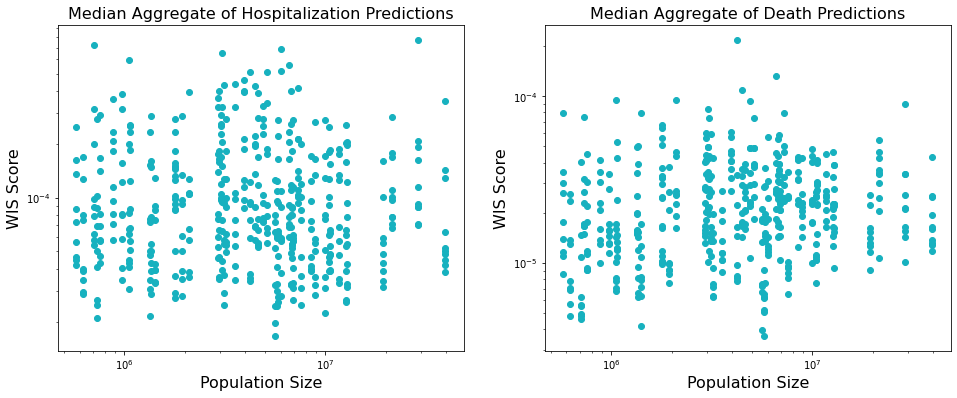

In [232]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.loglog(df_all_hosp['Population'],df_all_hosp['WIS']/df_all_hosp['Population'], 'o',  color = '#17B1BF')
plt.xlabel('Population Size', fontsize=16)
plt.ylabel('WIS Score', fontsize=16)
plt.title('Median Aggregate of Hospitalization Predictions', fontsize=16)


plt.subplot(1,2,2)
plt.loglog(df_all_death['Population'],df_all_death['WIS']/df_all_death['Population'], 'o', color = '#17B1BF')
plt.xlabel('Population Size', fontsize=16)
plt.ylabel('WIS Score', fontsize=16)
plt.title('Median Aggregate of Death Predictions', fontsize=16)

plt.show()

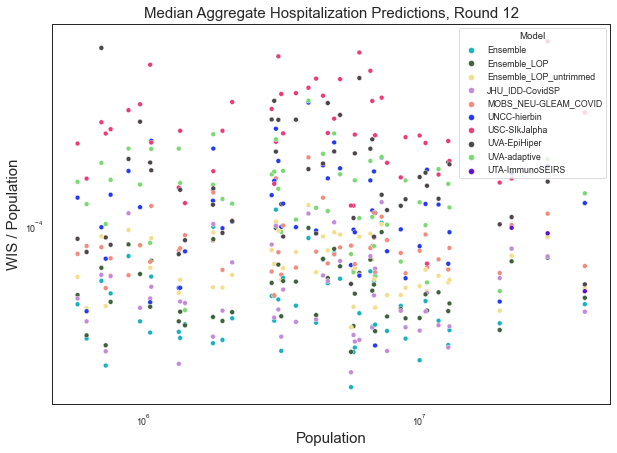

In [409]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)


sns.scatterplot(ax = ax, data = df_all_hosp,x=df_all_hosp['Population'],
                y=df_all_hosp['WIS']/df_all_hosp['Population']
                , hue='Model' ).set(title='Median Aggregate Hospitalization Predictions, Round 12')
ax.set( ylabel='WIS / Population')
plt.xscale('log')
plt.yscale('log')
plt.savefig('wispop_hosp.pdf')
plt.show()

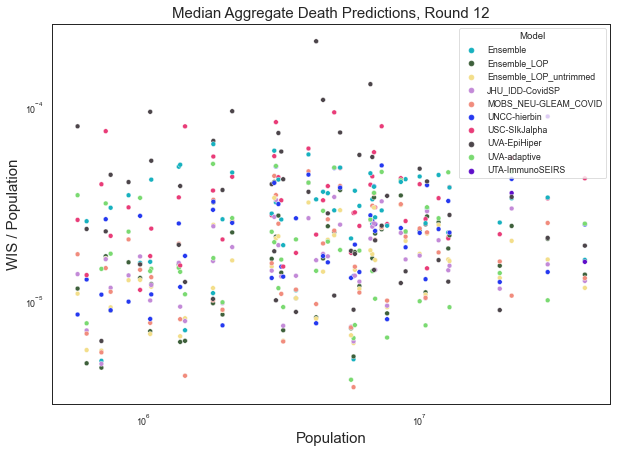

In [410]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)
sns.scatterplot(ax = ax, data=df_all_hosp, x=df_all_death['Population'],
                y=df_all_death['WIS']/df_all_death['Population'],
                hue='Model' ).set(title='Median Aggregate Death Predictions, Round 12')
ax.set( ylabel='WIS / Population')
plt.xscale('log')
plt.yscale('log')
plt.savefig('wispop_death.pdf')
plt.show()

# Ranking Distributions

In [327]:
dfrank = pd.DataFrame(columns=['Model', 'Location', 'Rank'])

states = list(df_all_hosp.Location.unique())
target = 'death'

if target == 'hosp':
    df = df_all_hosp
elif target == 'death':
    df = df_all_death
    
for state in states:
    filt = df[df['Location']==state]
    filt = filt.sort_values('WIS')

    rank = list(filt.Model)
    for model in models:
        if model not in rank:
            continue
        rankval = rank.index(model)+1
        
        new_row = {'Model':model, 'Location': state, 'Rank': rankval}
 
        dfrank = dfrank.append(new_row, ignore_index=True)

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1523099184.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfrank = dfrank.append(new_row, ignore_index=True)
/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1523099184.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfrank = dfrank.append(new_row, ignore_index=True)
/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1523099184.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfrank = dfrank.append(new_row, ignore_index=True)
/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1523099184.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

In [328]:
dfrank_death = dfrank

In [329]:
dfrank_hosp.head(10)

,Model,Location,Rank
0,Ensemble,Alabama,2
1,Ensemble_LOP,Alabama,3
2,Ensemble_LOP_untrimmed,Alabama,4
3,JHU_IDD-CovidSP,Alabama,5
4,MOBS_NEU-GLEAM_COVID,Alabama,1
5,UNCC-hierbin,Alabama,7
6,USC-SIkJalpha,Alabama,9
7,UVA-EpiHiper,Alabama,6
8,UVA-adaptive,Alabama,8
9,Ensemble,Alaska,1


In [330]:
dfrank_death.head(10)

,Model,Location,Rank
0,Ensemble,Alabama,5
1,Ensemble_LOP,Alabama,3
2,Ensemble_LOP_untrimmed,Alabama,2
3,JHU_IDD-CovidSP,Alabama,6
4,MOBS_NEU-GLEAM_COVID,Alabama,4
5,UNCC-hierbin,Alabama,7
6,USC-SIkJalpha,Alabama,9
7,UVA-EpiHiper,Alabama,1
8,UVA-adaptive,Alabama,8
9,Ensemble,Alaska,4


In [ ]:
fig, axes = plt.subplots(4,3, figsize=(15, 15), sharey=False)
fig.suptitle("Median Aggregate Ranking Distribution, Hospitalization Predictions, Round 12", fontsize=16)
models = list(dfrank_hosp.Model.unique())
for 

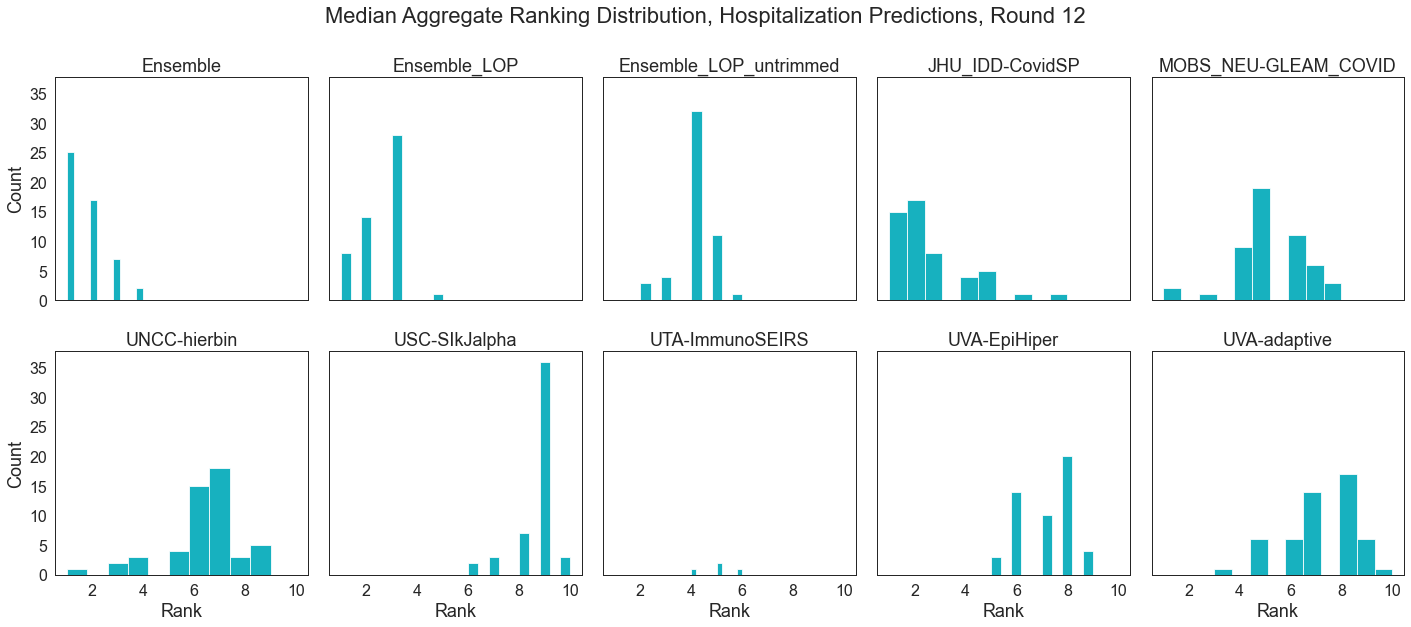

In [387]:

plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_hosp.plot.hist( column='Rank', by='Model', bins=10, grid=False, figsize=(20,9), layout=(2,5), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=16, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=18)
    a.set_ylabel("Count", fontsize=18)
    
plt.suptitle("Median Aggregate Ranking Distribution, Hospitalization Predictions, Round 12", fontsize=22)
plt.tight_layout()
plt.show()

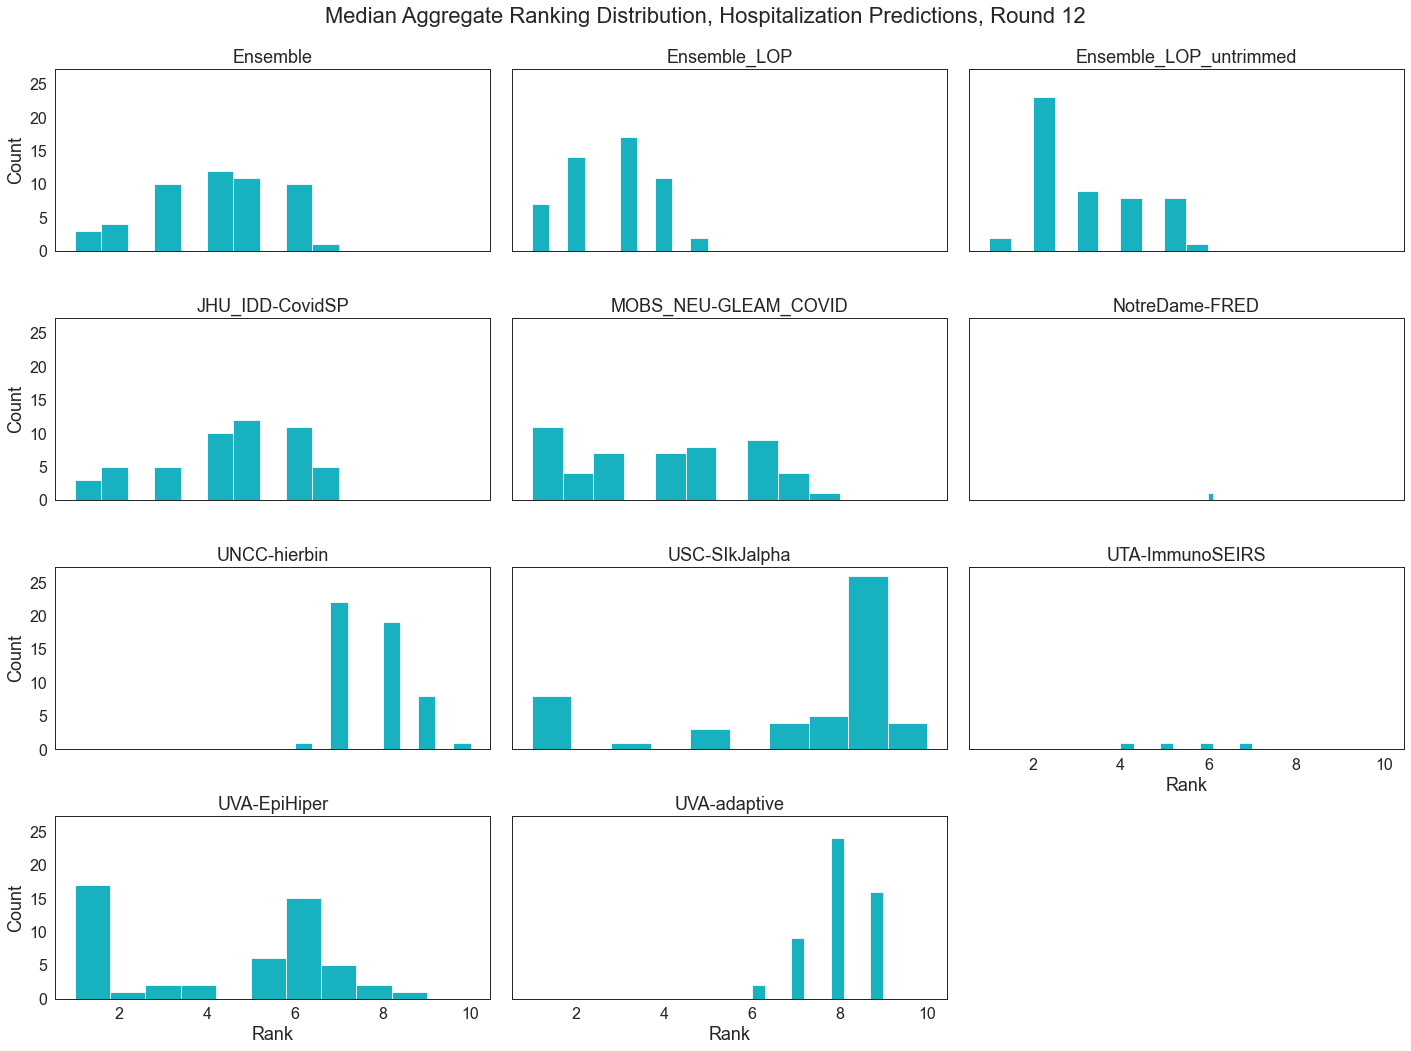

In [390]:
plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_death.plot.hist( column='Rank', by='Model', bins=10, grid=False, figsize=(20,15), layout=(4,3), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=16, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=18)
    a.set_ylabel("Count", fontsize=18)
    
plt.suptitle("Median Aggregate Ranking Distribution, Hospitalization Predictions, Round 12", fontsize=22)
plt.tight_layout()
plt.show()